## Datset preparation

In [1]:
# convert both dataset to standardized form, they should both contain:
# 1) variables: ['PR', 'TM', 'TX', 'TN']
# 2) "EPSG:31468" crs

In [2]:
import os
import pathlib
import affine
import time
import threading

In [3]:
import cartopy
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
import xarray as xr

In [4]:
from typing import List

In [5]:
### helper functions

In [6]:
def plot_samples_espg_crs(samples: List[xr.DataArray], figsize=(5, 5)) -> None:
    vmin = min(float(sample.min()) for sample in samples)
    vmax = max(float(sample.max()) for sample in samples)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

    fig = plt.figure(figsize=(figsize[0] * len(samples), figsize[1]))
    axes = []

    for idx, sample in enumerate(samples):
        ax = fig.add_subplot(1, len(samples), idx + 1, projection=cartopy.crs.epsg(31468))
        axes.append(ax)
        im = sample.plot(
            ax=ax,
            cmap="coolwarm",
            norm=norm,
            add_colorbar=False,
            transform=cartopy.crs.epsg(31468)
        )
        ax.add_feature(cartopy.feature.BORDERS)
        ax.add_feature(cartopy.feature.STATES, linestyle=":")
        ax.add_feature(cartopy.feature.RIVERS)
        ax.set_title(sample.attrs.get("long_name"))

    fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.7, pad=0.02)
    plt.show()

### Rekis dataset

In [7]:
### join all rekis data into one large dataset containing all variables.

In [8]:
base_path = "../../ReKIS/KlimRefDS_v3.1_1961-2023/Raster/Tag/GK4/"
variables = os.listdir(base_path)

In [9]:
print(f"available variables: {variables}")

available variables: ['RK', 'RR', 'TM', 'TX', 'TN']


In [10]:
variables.remove("RR") # remove rain rate

In [11]:
dataset_dict = {}
for variable in variables:
    dataset_dict[variable] = xr.open_mfdataset(
        f"{base_path}/{variable}/*.nc",
        decode_coords="all",
    )[variable]

rekis = xr.Dataset(dataset_dict)

In [12]:
rekis

<xarray.Dataset>
Dimensions:   (easting: 418, northing: 401, time: 23010)
Coordinates:
  * easting   (easting) float64 4.336e+06 4.336e+06 ... 4.752e+06 4.752e+06
  * northing  (northing) float64 5.954e+06 5.954e+06 ... 5.556e+06 5.554e+06
  * time      (time) datetime64[ns] 1961-01-01 1961-01-02 ... 2023-12-31
    crs       int32 -2147483647
Data variables:
    RK        (time, northing, easting) float32 dask.array<chunksize=(365, 401, 418), meta=np.ndarray>
    TM        (time, northing, easting) float32 dask.array<chunksize=(365, 401, 418), meta=np.ndarray>
    TX        (time, northing, easting) float32 dask.array<chunksize=(365, 401, 418), meta=np.ndarray>
    TN        (time, northing, easting) float32 dask.array<chunksize=(365, 401, 418), meta=np.ndarray>

In [13]:
### rename

In [14]:
rename_dict = {"RK": "PR"}
rekis = rekis.rename(rename_dict)
rekis.keys()

KeysView(<xarray.Dataset>
Dimensions:   (easting: 418, northing: 401, time: 23010)
Coordinates:
  * easting   (easting) float64 4.336e+06 4.336e+06 ... 4.752e+06 4.752e+06
  * northing  (northing) float64 5.954e+06 5.954e+06 ... 5.556e+06 5.554e+06
  * time      (time) datetime64[ns] 1961-01-01 1961-01-02 ... 2023-12-31
    crs       int32 -2147483647
Data variables:
    PR        (time, northing, easting) float32 dask.array<chunksize=(365, 401, 418), meta=np.ndarray>
    TM        (time, northing, easting) float32 dask.array<chunksize=(365, 401, 418), meta=np.ndarray>
    TX        (time, northing, easting) float32 dask.array<chunksize=(365, 401, 418), meta=np.ndarray>
    TN        (time, northing, easting) float32 dask.array<chunksize=(365, 401, 418), meta=np.ndarray>)

In [15]:
### slice data

In [16]:
rekis = rekis.isel(
    easting=slice(0, 400),
    northing=slice(0, 400)
)

In [58]:
sample_date = "2005-05-01"

In [59]:
y_rekis_tm = rekis["TM"]
y_rekis_tm_sample = y_rekis_tm.sel(time=sample_date)

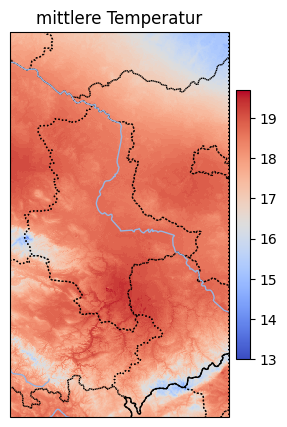

In [60]:
plot_samples_espg_crs([y_rekis_tm_sample])

In [21]:
### upscale rekis dataset

In [22]:
num_threads = threading.active_count()
print(f"Number of active threads: {num_threads}")

Number of active threads: 10


In [23]:
start = time.time()
rekis.rio.set_spatial_dims("easting", "northing")
x_rekis = rekis.rio.reproject(
    rekis.rio.crs, 
    resolution=(10_000, 10_000), 
    resampling=rasterio.enums.Resampling.cubic_spline,
    num_threads=10
)
end = time.time()

print(f"Time diff: {(end - start) / 60} min")

Time diff: 18.666805283228555 min


In [61]:
x_rekis_tm_sample = x_rekis['TM'].sel(time=sample_date)

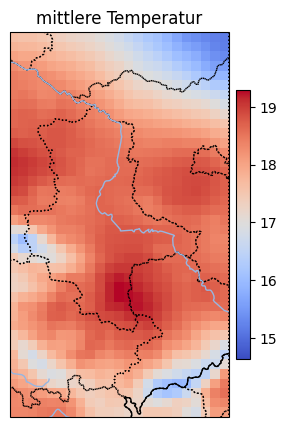

In [62]:
plot_samples_espg_crs([x_rekis_tm_sample])

In [26]:
### save rekis

In [27]:
time_min, time_max = min(rekis["time"]), max(rekis["time"])

In [28]:
years = pd.date_range(
    start=pd.Timestamp('2012'),
    end=time_max.values.astype('datetime64[Y]') + 1, 
    freq='YE'
).year

In [29]:
years

Index([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], dtype='int32')

In [30]:
data_path = ...

In [31]:
# for year in years:
#     yearly_data = rekis.sel(time=str(year))
#     yearly_data.to_netcdf(f"{data_path}/rekis_{year}.nc")

### Cordex dataset

In [32]:
### Join all cordex data into one large dataset containg all variables.

In [33]:
# regional climate model to downscale
rcm = "GERICS-REMO2015_v1_day"

In [34]:
base_path = "../../CORDEX/"
variables = os.listdir(base_path)

In [35]:
print(f"available variables: {variables}")

available variables: ['tas', 'orog', 'tasmin', 'pr', 'sftlf', 'tasmax', 'mrso']


In [36]:
remove = ["orog", "sftlf", "mrso"]
variables = [var for var in variables if var not in remove]

In [37]:
dataset_dict = {}
for variable in variables:
    dataset_dict[variable] = xr.open_mfdataset(
        f"{base_path}/{variable}/*{rcm}*.nc",
        decode_coords="all",
    )[variable]

cordex = xr.Dataset(dataset_dict)

In [38]:
cordex

<xarray.Dataset>
Dimensions:                     (time: 12418, rlat: 412, rlon: 424)
Coordinates:
  * time                        (time) datetime64[ns] 1979-01-02T12:00:00 ......
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.72 21.84
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.04 18.16
    rotated_latitude_longitude  int32 -2147483647
    lat                         (rlat, rlon) float32 22.02 22.06 ... 66.83 66.76
    lon                         (rlat, rlon) float32 -10.14 -10.04 ... 64.95
    height                      float64 2.0
Data variables:
    tas                         (time, rlat, rlon) float32 dask.array<chunksize=(730, 412, 424), meta=np.ndarray>
    tasmin                      (time, rlat, rlon) float32 dask.array<chunksize=(730, 412, 424), meta=np.ndarray>
    pr                          (time, rlat, rlon) float32 dask.array<chunksize=(730, 412, 424), meta=np.ndarray>
    tasmax                      (time, rlat, rlon) float32 dask.array<chunksize=(730, 412, 424), meta=np.ndarray>

In [39]:
### reproject cordex dataset to match the rekis dataset

In [40]:
start = time.time()
cordex_1d = cordex.drop_vars(["lat", "lon"])
espg_cordex = cordex_1d.rio.reproject(
    dst_crs="EPSG:31468",
    transform=affine.Affine(10000.0, 0.0, 4335000.0, 0.0, -10000.0, 5955000.0),
    shape=(40, 40),
    resampling=rasterio.enums.Resampling.cubic_spline,
)
end = time.time()

print(f"Time diff: {(end - start) / 60}min")

Time diff: 3.3995540420214336min


In [41]:
rename_dict = {
    "tas": "TM",
    "tasmin": "TN",
    "tasmax": "TX",
    "pr": "PR",
}

In [42]:
espg_cordex = espg_cordex.rename(rename_dict)
espg_cordex.keys()

KeysView(<xarray.Dataset>
Dimensions:                     (x: 40, y: 40, time: 12418)
Coordinates:
  * x                           (x) float64 4.34e+06 4.35e+06 ... 4.73e+06
  * y                           (y) float64 5.95e+06 5.94e+06 ... 5.56e+06
    height                      float64 2.0
  * time                        (time) datetime64[ns] 1979-01-02T12:00:00 ......
    rotated_latitude_longitude  int64 0
Data variables:
    TM                          (time, y, x) float32 268.2 268.1 ... 275.4 274.9
    TN                          (time, y, x) float32 266.0 266.1 ... 274.0 273.5
    PR                          (time, y, x) float32 1.696e-06 ... 2.03e-06
    TX                          (time, y, x) float32 269.5 269.3 ... 277.3 276.7)

In [43]:
### conversion from K to °C
for variable in ["TM", "TN", "TX"]:
    espg_cordex[variable] -= 273.15

In [63]:
espg_cordex_tm = espg_cordex["TM"]
x_cordex_tm_sample = espg_cordex_tm.sel(time=sample_date + "T12:00:00")

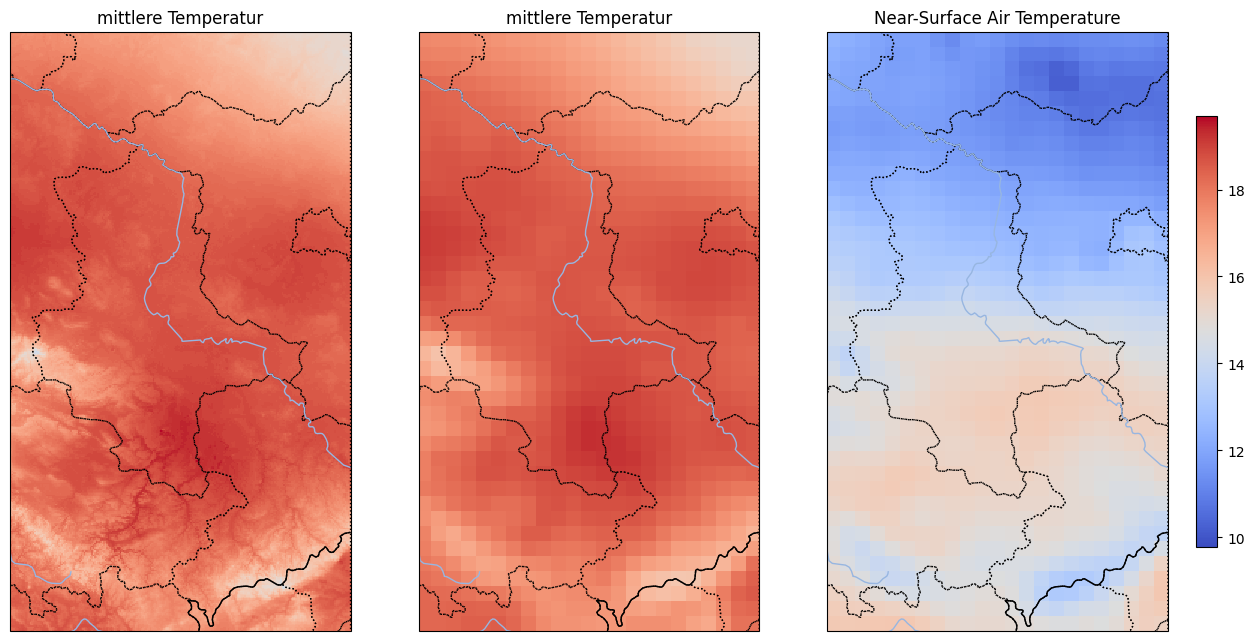

In [64]:
plot_samples_espg_crs([y_rekis_tm_sample, x_rekis_tm_sample, x_cordex_tm_sample], figsize=(6, 8))

In [49]:
### save cordex 

In [50]:
time_min, time_max = min(espg_cordex["time"]), max(espg_cordex["time"])

In [51]:
years = pd.date_range(
    start=time_min.values.astype('datetime64[Y]'), 
    end=time_max.values.astype('datetime64[Y]') + 1, 
    freq='YE'
).year

In [52]:
years

Index([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012],
      dtype='int32')

In [53]:
data_path = ...

In [54]:
# for year in years:
#     yearly_data = espg_cordex.sel(time=str(year))
#     yearly_data.to_netcdf(f"{data_path}/cordex_{year}.nc")

In [55]:
### data test samples

In [56]:
# rekis_test_sample = rekis.sel(time=slice("2000-01-01", "2000-02-01"))
# rekis_test_sample.to_netcdf("rekis_test_sample.nc")

In [57]:
# cordex_test_sample = espg_cordex.sel(time=slice("2000-01-01", "2000-03-01"))
# cordex_test_sample.to_netcdf("cordex_test_sample.nc")